# Regresión Logística & Credit Scoring

## Preparación de ambiente

### Carga de módulos

In [1]:
import numpy as np
import pandas as pd
import cufflinks as cf
from sklearn.linear_model import LogisticRegression

cf.go_offline()
pd.set_option('display.float_format', lambda x: '%.5f' % x)

### Funciones auxiliares

In [2]:
def IV(df, var, tgt):
    aux = df[[var, tgt]].groupby(var).agg(["count", "sum"])
    aux["evento"] = aux[tgt, "sum"]
    aux["no_evento"] = aux[tgt, "count"] - aux[tgt, "sum"]
    aux["%evento"] = aux["evento"] / aux["evento"].sum()
    aux["%no_evento"] = aux["no_evento"] / aux["no_evento"].sum()
    aux["WOE"] = np.log(aux["%no_evento"] / aux["%evento"])
    aux["IV"] = (aux["%no_evento"] - aux["%evento"])*aux["WOE"]
    display(aux)
    return aux["IV"].sum()

In [3]:
def WOE(df, var, tgt):
    aux = df[[var, tgt]].groupby(var).agg(["count", "sum"])
    aux["evento"] = aux[tgt, "sum"]
    aux["no_evento"] = aux[tgt, "count"] - aux[tgt, "sum"]
    aux["%evento"] = aux["evento"] / aux["evento"].sum()
    aux["%no_evento"] = aux["no_evento"] / aux["no_evento"].sum()
    aux["WOE"] = np.log(aux["%no_evento"] / aux["%evento"])
    aux.columns = aux.columns.droplevel(1)
    aux = aux[["WOE"]].reset_index().rename(columns={"WOE": f"W_{var}"})
    df = df.merge(aux, on = var, how = "left")
    return df

## Data Wrangling

### Lectura de datos

In [4]:
df = pd.read_csv("OnlineNewsPopularity.csv")

In [5]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.00000,12.00000,219.00000,0.66359,1.00000,0.81538,4.00000,2.00000,1.00000,...,0.10000,0.70000,-0.35000,-0.60000,-0.20000,0.50000,-0.18750,0.00000,0.18750,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.00000,9.00000,255.00000,0.60474,1.00000,0.79195,3.00000,1.00000,1.00000,...,0.03333,0.70000,-0.11875,-0.12500,-0.10000,0.00000,0.00000,0.50000,0.00000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.00000,9.00000,211.00000,0.57513,1.00000,0.66387,3.00000,1.00000,1.00000,...,0.10000,1.00000,-0.46667,-0.80000,-0.13333,0.00000,0.00000,0.50000,0.00000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.00000,9.00000,531.00000,0.50379,1.00000,0.66563,9.00000,0.00000,1.00000,...,0.13636,0.80000,-0.36970,-0.60000,-0.16667,0.00000,0.00000,0.50000,0.00000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.00000,13.00000,1072.00000,0.41565,1.00000,0.54089,19.00000,19.00000,20.00000,...,0.03333,1.00000,-0.22019,-0.50000,-0.05000,0.45455,0.13636,0.04545,0.13636,505


In [6]:
ls_cont = ['n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity']
target = "success"

### Construcción de variable objetivo **discreta**

In [7]:
df["success"] = (df["shares"] <= df["shares"].quantile(.75))*1

In [8]:
df["success"].shape

(39644,)

In [9]:
df["success"].value_counts(True)

1   0.75709
0   0.24291
Name: success, dtype: float64

### Regresión logística

In [10]:
X = df[ls_cont]

In [11]:
y = df[target]

In [12]:
logreg = LogisticRegression(max_iter=10000)

In [13]:
logreg.fit(X, y)

LogisticRegression(max_iter=10000)

In [14]:
logreg.score(X, y)

0.7568610634648371

In [15]:
pd.DataFrame(zip(ls_cont, logreg.coef_[0])).sort_values(by=1)

,0,1
25,kw_avg_avg,-0.00068
5,num_hrefs,-0.00038
7,num_imgs,-0.00025
1,n_tokens_content,-0.00010
18,kw_max_min,-0.00005
36,is_weekend,-0.00003
14,data_channel_is_socmed,-0.00002
3,n_non_stop_words,-0.00002
35,weekday_is_sunday,-0.00001
15,data_channel_is_tech,-0.00001


## Credit Scoring

### Discretización

In [16]:
ls_data_channel = ['data_channel_is_lifestyle',
'data_channel_is_entertainment', 'data_channel_is_bus',
'data_channel_is_socmed', 'data_channel_is_tech',
'data_channel_is_world']
ls_weekday = ['weekday_is_monday', 'weekday_is_tuesday',
'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
'weekday_is_saturday', 'weekday_is_sunday']

In [17]:
for channel in ls_data_channel:
    df[channel] = df[channel].map({0: '', 1: channel.split("_")[-1]})

In [18]:
df["channel"] = df[ls_data_channel].sum(axis=1)

In [25]:
df["channel"]

0        entertainment
1                  bus
2                  bus
3        entertainment
4                 tech
             ...      
39639             tech
39640           socmed
39641                 
39642            world
39643    entertainment
Name: channel, Length: 39644, dtype: object

In [19]:
for day in ls_weekday:
    df[day] = df[day].map({0: '', 1: day.split("_")[-1]})

In [20]:
df["day"] = df[ls_weekday].sum(axis=1)

In [21]:
ls_cont = [x for x in ls_cont if x not in ls_weekday+ls_data_channel]

In [22]:
for var in ls_cont:
    df[f"C_{var}"] = pd.cut(df[var], bins=5).astype(str)

In [23]:
new_disc = [x for x in df.columns if x.startswith("C_")] +["day", "channel"]

In [26]:
new_disc

['C_n_tokens_title',
 'C_n_tokens_content',
 'C_n_unique_tokens',
 'C_n_non_stop_words',
 'C_n_non_stop_unique_tokens',
 'C_num_hrefs',
 'C_num_self_hrefs',
 'C_num_imgs',
 'C_num_videos',
 'C_average_token_length',
 'C_num_keywords',
 'C_kw_min_min',
 'C_kw_max_min',
 'C_kw_avg_min',
 'C_kw_min_max',
 'C_kw_max_max',
 'C_kw_avg_max',
 'C_kw_min_avg',
 'C_kw_max_avg',
 'C_kw_avg_avg',
 'C_self_reference_min_shares',
 'C_self_reference_max_shares',
 'C_self_reference_avg_sharess',
 'C_is_weekend',
 'C_LDA_00',
 'C_LDA_01',
 'C_LDA_02',
 'C_LDA_03',
 'C_LDA_04',
 'C_global_subjectivity',
 'C_global_sentiment_polarity',
 'C_global_rate_positive_words',
 'C_global_rate_negative_words',
 'C_rate_positive_words',
 'C_rate_negative_words',
 'C_avg_positive_polarity',
 'C_min_positive_polarity',
 'C_max_positive_polarity',
 'C_avg_negative_polarity',
 'C_min_negative_polarity',
 'C_max_negative_polarity',
 'C_title_subjectivity',
 'C_title_sentiment_polarity',
 'C_abs_title_subjectivity',
 'C_

In [24]:
pd.cut(df[var], bins=5).astype(str)

0        (-0.001, 0.2]
1        (-0.001, 0.2]
2        (-0.001, 0.2]
3        (-0.001, 0.2]
4        (-0.001, 0.2]
             ...      
39639    (-0.001, 0.2]
39640       (0.8, 1.0]
39641    (-0.001, 0.2]
39642    (-0.001, 0.2]
39643       (0.2, 0.4]
Name: abs_title_sentiment_polarity, Length: 39644, dtype: object

In [132]:
df[["n_tokens_title", "C_n_tokens_title"]]

,n_tokens_title,C_n_tokens_title
0,12.00000,"(10.4, 14.6]"
1,9.00000,"(6.2, 10.4]"
2,9.00000,"(6.2, 10.4]"
3,9.00000,"(6.2, 10.4]"
4,13.00000,"(10.4, 14.6]"
...,...,...
39639,11.00000,"(10.4, 14.6]"
39640,12.00000,"(10.4, 14.6]"
39641,10.00000,"(6.2, 10.4]"
39642,6.00000,"(1.979, 6.2]"


### IV

In [133]:
tgt = target

In [134]:
df_iv = pd.DataFrame(columns=["iv"])
for var in new_disc:
    df_iv.loc[var, "iv"] = IV(df = df, var = var, tgt = tgt)

success        evento no_evento %evento %no_evento      WOE  \
                   count    sum                                                
C_n_tokens_title                                                               
(1.979, 6.2]        1023    745    745       278 0.02482    0.02887  0.15102   
(10.4, 14.6]       17501  13401  13401      4100 0.44649    0.42575 -0.04756   
(14.6, 18.8]        1128    875    875       253 0.02915    0.02627 -0.10405   
(18.8, 23.0]           9      6      6         3 0.00020    0.00031  0.44363   
(6.2, 10.4]        19983  14987  14987      4996 0.49933    0.51880  0.03824   

                      IV  
                          
C_n_tokens_title          
(1.979, 6.2]     0.00061  
(10.4, 14.6]     0.00099  
(14.6, 18.8]     0.00030  
(18.8, 23.0]     0.00005  
(6.2, 10.4]      0.00074

success        evento no_evento %evento %no_evento  \
                     count    sum                                       
C_n_tokens_content                                                      
(-8.474, 1694.8]     38516  29221  29221      9295 0.97358    0.96521   
(1694.8, 3389.6]      1054    751    751       303 0.02502    0.03146   
(3389.6, 5084.4]        59     32     32        27 0.00107    0.00280   
(5084.4, 6779.2]         7      6      6         1 0.00020    0.00010   
(6779.2, 8474.0]         8      4      4         4 0.00013    0.00042   

                        WOE      IV  
                                     
C_n_tokens_content                   
(-8.474, 1694.8]   -0.00863 0.00007  
(1694.8, 3389.6]    0.22911 0.00148  
(3389.6, 5084.4]    0.96688 0.00168  
(5084.4, 6779.2]   -0.65498 0.00006  
(6779.2, 8474.0]    1.13678 0.00032

success        evento no_evento %evento %no_evento      WOE  \
                    count    sum                                                
C_n_unique_tokens                                                               
(-0.701, 140.2]     39643  30014  30014      9629 1.00000    0.99990 -0.00010   
(560.8, 701.0]          1      0      0         1 0.00000    0.00010      inf   

                       IV  
                           
C_n_unique_tokens          
(-0.701, 140.2]   0.00000  
(560.8, 701.0]        inf

success        evento no_evento %evento %no_evento  \
                     count    sum                                       
C_n_non_stop_words                                                      
(-1.042, 208.4]      39643  30014  30014      9629 1.00000    0.99990   
(833.6, 1042.0]          1      0      0         1 0.00000    0.00010   

                        WOE      IV  
                                     
C_n_non_stop_words                   
(-1.042, 208.4]    -0.00010 0.00000  
(833.6, 1042.0]         inf     inf

success        evento no_evento %evento %no_evento  \
                             count    sum                                       
C_n_non_stop_unique_tokens                                                      
(-0.65, 130.0]               39643  30014  30014      9629 1.00000    0.99990   
(520.0, 650.0]                   1      0      0         1 0.00000    0.00010   

                                WOE      IV  
                                             
C_n_non_stop_unique_tokens                   
(-0.65, 130.0]             -0.00010 0.00000  
(520.0, 650.0]                  inf     inf

success        evento no_evento %evento %no_evento      WOE  \
                 count    sum                                                
C_num_hrefs                                                                  
(-0.304, 60.8]   39330  29817  29817      9513 0.99344    0.98785 -0.00564   
(121.6, 182.4]      18      8      8        10 0.00027    0.00104  1.35992   
(182.4, 243.2]       2      0      0         2 0.00000    0.00021      inf   
(243.2, 304.0]       1      0      0         1 0.00000    0.00010      inf   
(60.8, 121.6]      293    189    189       104 0.00630    0.01080  0.53942   

                    IV  
                        
C_num_hrefs             
(-0.304, 60.8] 0.00003  
(121.6, 182.4] 0.00105  
(182.4, 243.2]     inf  
(243.2, 304.0]     inf  
(60.8, 121.6]  0.00243

/home/oscar/VirtualEnvs/lcd/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



success        evento no_evento %evento %no_evento      WOE  \
                   count    sum                                                
C_num_self_hrefs                                                               
(-0.116, 23.2]     39389  29826  29826      9563 0.99374    0.99304 -0.00070   
(23.2, 46.4]         232    179    179        53 0.00596    0.00550 -0.08031   
(46.4, 69.6]          21      7      7        14 0.00023    0.00145  1.82993   
(69.6, 92.8]           1      1      1         0 0.00003    0.00000     -inf   
(92.8, 116.0]          1      1      1         0 0.00003    0.00000     -inf   

                      IV  
                          
C_num_self_hrefs          
(-0.116, 23.2]   0.00000  
(23.2, 46.4]     0.00004  
(46.4, 69.6]     0.00223  
(69.6, 92.8]         inf  
(92.8, 116.0]        inf

success        evento no_evento %evento %no_evento      WOE  \
                 count    sum                                                
C_num_imgs                                                                   
(-0.128, 25.6]   38536  29225  29225      9311 0.97371    0.96687 -0.00705   
(102.4, 128.0]       4      2      2         2 0.00007    0.00021  1.13678   
(25.6, 51.2]       937    676    676       261 0.02252    0.02710  0.18511   
(51.2, 76.8]       136     93     93        43 0.00310    0.00447  0.36538   
(76.8, 102.4]       31     18     18        13 0.00060    0.00135  0.81136   

                    IV  
                        
C_num_imgs              
(-0.128, 25.6] 0.00005  
(102.4, 128.0] 0.00016  
(25.6, 51.2]   0.00085  
(51.2, 76.8]   0.00050  
(76.8, 102.4]  0.00061

success        evento no_evento %evento %no_evento      WOE  \
                 count    sum                                                
C_num_videos                                                                 
(-0.091, 18.2]   38994  29526  29526      9468 0.98374    0.98318 -0.00057   
(18.2, 36.4]       605    459    459       146 0.01529    0.01516 -0.00866   
(36.4, 54.6]        22     13     13         9 0.00043    0.00093  0.76906   
(54.6, 72.8]         8      5      5         3 0.00017    0.00031  0.62596   
(72.8, 91.0]        15     11     11         4 0.00037    0.00042  0.12518   

                    IV  
                        
C_num_videos            
(-0.091, 18.2] 0.00000  
(18.2, 36.4]   0.00000  
(36.4, 54.6]   0.00039  
(54.6, 72.8]   0.00009  
(72.8, 91.0]   0.00001

success        evento no_evento %evento %no_evento  \
                         count    sum                                       
C_average_token_length                                                      
(-0.00804, 1.608]         1181    803    803       378 0.02675    0.03925   
(3.217, 4.825]           27195  20386  20386      6809 0.67922    0.70706   
(4.825, 6.433]           11259   8818   8818      2441 0.29380    0.25348   
(6.433, 8.042]               9      7      7         2 0.00023    0.00021   

                            WOE      IV  
                                         
C_average_token_length                   
(-0.00804, 1.608]       0.38332 0.00479  
(3.217, 4.825]          0.04018 0.00112  
(4.825, 6.433]         -0.14761 0.00595  
(6.433, 8.042]         -0.11598 0.00000

success        evento no_evento %evento %no_evento      WOE  \
                 count    sum                                                
C_num_keywords                                                               
(0.991, 2.8]        96     84     84        12 0.00280    0.00125 -0.80913   
(2.8, 4.6]        3062   2479   2479       583 0.08259    0.06054 -0.31064   
(4.6, 6.4]       11630   9027   9027      2603 0.30076    0.27030 -0.10677   
(6.4, 8.2]       13416  10046  10046      3370 0.33471    0.34995  0.04452   
(8.2, 10.0]      11440   8378   8378      3062 0.27914    0.31796  0.13024   

                    IV  
                        
C_num_keywords          
(0.991, 2.8]   0.00126  
(2.8, 4.6]     0.00685  
(4.6, 6.4]     0.00325  
(6.4, 8.2]     0.00068  
(8.2, 10.0]    0.00506

/home/oscar/VirtualEnvs/lcd/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



success        evento no_evento %evento %no_evento      WOE  \
                 count    sum                                                
C_kw_min_min                                                                 
(-1.378, 74.6]   34985  26561  26561      8424 0.88495    0.87477 -0.01158   
(150.2, 225.8]    4639   3438   3438      1201 0.11455    0.12471  0.08505   
(225.8, 301.4]       2      2      2         0 0.00007    0.00000     -inf   
(301.4, 377.0]       2      2      2         0 0.00007    0.00000     -inf   
(74.6, 150.2]       16     11     11         5 0.00037    0.00052  0.34832   

                    IV  
                        
C_kw_min_min            
(-1.378, 74.6] 0.00012  
(150.2, 225.8] 0.00086  
(225.8, 301.4]     inf  
(301.4, 377.0]     inf  
(74.6, 150.2]  0.00005

success        evento no_evento %evento %no_evento  \
                       count    sum                                       
C_kw_max_min                                                              
(-298.4, 59680.0]      39620  29997  29997      9623 0.99943    0.99927   
(119360.0, 179040.0]       4      3      3         1 0.00010    0.00010   
(238720.0, 298400.0]       2      1      1         1 0.00003    0.00010   
(59680.0, 119360.0]       18     13     13         5 0.00043    0.00052   

                          WOE      IV  
                                       
C_kw_max_min                           
(-298.4, 59680.0]    -0.00016 0.00000  
(119360.0, 179040.0]  0.03817 0.00000  
(238720.0, 298400.0]  1.13678 0.00008  
(59680.0, 119360.0]   0.18127 0.00002

success        evento no_evento %evento %no_evento  \
                         count    sum                                       
C_kw_avg_min                                                                
(-43.829, 8564.771]      39619  29995  29995      9624 0.99937    0.99938   
(17130.543, 25696.314]       2      1      1         1 0.00003    0.00010   
(25696.314, 34262.086]       2      1      1         1 0.00003    0.00010   
(34262.086, 42827.857]       3      2      2         1 0.00007    0.00010   
(8564.771, 17130.543]       18     15     15         3 0.00050    0.00031   

                            WOE      IV  
                                         
C_kw_avg_min                             
(-43.829, 8564.771]     0.00001 0.00000  
(17130.543, 25696.314]  1.13678 0.00008  
(25696.314, 34262.086]  1.13678 0.00008  
(34262.086, 42827.857]  0.44363 0.00002  
(8564.771, 17130.543]  -0.47266 0.00009

success        evento no_evento %evento %no_evento  \
                       count    sum                                       
C_kw_min_max                                                              
(-843.3, 168660.0]     39173  29653  29653      9520 0.98797    0.98858   
(168660.0, 337320.0]     246    188    188        58 0.00626    0.00602   
(337320.0, 505980.0]       7      3      3         4 0.00010    0.00042   
(505980.0, 674640.0]      97     70     70        27 0.00233    0.00280   
(674640.0, 843300.0]     121    100    100        21 0.00333    0.00218   

                          WOE      IV  
                                       
C_kw_min_max                           
(-843.3, 168660.0]    0.00061 0.00000  
(168660.0, 337320.0] -0.03922 0.00001  
(337320.0, 505980.0]  1.42446 0.00045  
(505980.0, 674640.0]  0.18412 0.00009  
(674640.0, 843300.0] -0.42387 0.00049

/home/oscar/VirtualEnvs/lcd/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



success        evento no_evento %evento %no_evento  \
                       count    sum                                       
C_kw_max_max                                                              
(-843.3, 168660.0]      3100   2381   2381       719 0.07933    0.07466   
(168660.0, 337320.0]      85     55     55        30 0.00183    0.00312   
(337320.0, 505980.0]       2      2      2         0 0.00007    0.00000   
(505980.0, 674640.0]    2267   1599   1599       668 0.05328    0.06937   
(674640.0, 843300.0]   34190  25977  25977      8213 0.86550    0.85286   

                          WOE      IV  
                                       
C_kw_max_max                           
(-843.3, 168660.0]   -0.06063 0.00028  
(168660.0, 337320.0]  0.53064 0.00068  
(337320.0, 505980.0]     -inf     inf  
(505980.0, 674640.0]  0.26394 0.00425  
(674640.0, 843300.0] -0.01471 0.00019

success        evento no_evento %evento %no_evento  \
                       count    sum                                       
C_kw_avg_max                                                              
(-843.3, 168660.0]      9349   7103   7103      2246 0.23666    0.23323   
(168660.0, 337320.0]   20923  16253  16253      4670 0.54151    0.48494   
(337320.0, 505980.0]    7288   5201   5201      2087 0.17329    0.21672   
(505980.0, 674640.0]    1788   1242   1242       546 0.04138    0.05670   
(674640.0, 843300.0]     296    215    215        81 0.00716    0.00841   

                          WOE      IV  
                                       
C_kw_avg_max                           
(-843.3, 168660.0]   -0.01459 0.00005  
(168660.0, 337320.0] -0.11034 0.00624  
(337320.0, 505980.0]  0.22366 0.00971  
(505980.0, 674640.0]  0.31492 0.00482  
(674640.0, 843300.0]  0.16059 0.00020

success        evento no_evento %evento %no_evento  \
                       count    sum                                       
C_kw_min_avg                                                              
(-4.614, 721.808]      17799  13597  13597      4202 0.45302    0.43634   
(1444.616, 2167.424]    7053   5529   5529      1524 0.18421    0.15826   
(2167.424, 2890.232]    5136   3518   3518      1618 0.11721    0.16802   
(2890.232, 3613.04]     3568   2161   2161      1407 0.07200    0.14611   
(721.808, 1444.616]     6088   5209   5209       879 0.17355    0.09128   

                          WOE      IV  
                                       
C_kw_min_avg                           
(-4.614, 721.808]    -0.03751 0.00063  
(1444.616, 2167.424] -0.15189 0.00394  
(2167.424, 2890.232]  0.36008 0.01829  
(2890.232, 3613.04]   0.70767 0.05244  
(721.808, 1444.616]  -0.64258 0.05287

success        evento no_evento %evento %no_evento  \
                       count    sum                                       
C_kw_max_avg                                                              
(-298.4, 59680.0]      39559  29962  29962      9597 0.99827    0.99657   
(119360.0, 179040.0]      14      8      8         6 0.00027    0.00062   
(179040.0, 238720.0]       1      0      0         1 0.00000    0.00010   
(238720.0, 298400.0]       2      1      1         1 0.00003    0.00010   
(59680.0, 119360.0]       68     43     43        25 0.00143    0.00260   

                          WOE      IV  
                                       
C_kw_max_avg                           
(-298.4, 59680.0]    -0.00170 0.00000  
(119360.0, 179040.0]  0.84910 0.00030  
(179040.0, 238720.0]      inf     inf  
(238720.0, 298400.0]  1.13678 0.00008  
(59680.0, 119360.0]   0.59446 0.00069

success        evento no_evento %evento %no_evento  \
                         count    sum                                       
C_kw_avg_avg                                                                
(-43.568, 8713.532]      39464  29904  29904      9560 0.99634    0.99273   
(17427.064, 26140.596]      15      6      6         9 0.00020    0.00093   
(26140.596, 34854.128]       5      4      4         1 0.00013    0.00010   
(34854.128, 43567.66]        4      1      1         3 0.00003    0.00031   
(8713.532, 17427.064]      156     99     99        57 0.00330    0.00592   

                            WOE      IV  
                                         
C_kw_avg_avg                             
(-43.568, 8713.532]    -0.00362 0.00001  
(17427.064, 26140.596]  1.54225 0.00113  
(26140.596, 34854.128] -0.24951 0.00001  
(34854.128, 43567.66]   2.23539 0.00062  
(8713.532, 17427.064]   0.58471 0.00153

success        evento no_evento %evento  \
                              count    sum                            
C_self_reference_min_shares                                           
(-843.3, 168660.0]            39604  29991  29991      9613 0.99923   
(168660.0, 337320.0]             15      7      7         8 0.00023   
(505980.0, 674640.0]             17     11     11         6 0.00037   
(674640.0, 843300.0]              8      5      5         3 0.00017   

                            %no_evento      WOE      IV  
                                                         
C_self_reference_min_shares                              
(-843.3, 168660.0]             0.99823 -0.00100 0.00000  
(168660.0, 337320.0]           0.00083  1.27031 0.00076  
(505980.0, 674640.0]           0.00062  0.53064 0.00014  
(674640.0, 843300.0]           0.00031  0.62596 0.00009

success        evento no_evento %evento  \
                              count    sum                            
C_self_reference_max_shares                                           
(-843.3, 168660.0]            39442  29889  29889      9553 0.99584   
(168660.0, 337320.0]             87     57     57        30 0.00190   
(337320.0, 505980.0]              1      0      0         1 0.00000   
(505980.0, 674640.0]             65     44     44        21 0.00147   
(674640.0, 843300.0]             49     24     24        25 0.00080   

                            %no_evento      WOE      IV  
                                                         
C_self_reference_max_shares                              
(-843.3, 168660.0]             0.99200 -0.00385 0.00001  
(168660.0, 337320.0]           0.00312  0.49493 0.00060  
(337320.0, 505980.0]           0.00010      inf     inf  
(505980.0, 674640.0]           0.00218  0.39711 0.00028  
(674640.0, 843300.0]           0.00260  1.17760 0.00212

success        evento no_evento %evento  \
                               count    sum                            
C_self_reference_avg_sharess                                           
(-843.3, 168660.0]             39537  29950  29950      9587 0.99787   
(168660.0, 337320.0]              60     36     36        24 0.00120   
(337320.0, 505980.0]              22     12     12        10 0.00040   
(505980.0, 674640.0]              17     11     11         6 0.00037   
(674640.0, 843300.0]               8      5      5         3 0.00017   

                             %no_evento      WOE      IV  
                                                          
C_self_reference_avg_sharess                              
(-843.3, 168660.0]              0.99553 -0.00234 0.00001  
(168660.0, 337320.0]            0.00249  0.73132 0.00095  
(337320.0, 505980.0]            0.00104  0.95446 0.00061  
(505980.0, 674640.0]            0.00062  0.53064 0.00014  
(674640.0, 843300.0]            0.00031  0.62596 0.00009

success        evento no_evento %evento %no_evento      WOE  \
                count    sum                                                
C_is_weekend                                                                
(-0.001, 0.2]   34454  26576  26576      7878 0.88545    0.81807 -0.07915   
(0.8, 1.0]       5190   3438   3438      1752 0.11455    0.18193  0.46265   

                   IV  
                       
C_is_weekend           
(-0.001, 0.2] 0.00533  
(0.8, 1.0]    0.03118

success        evento no_evento %evento %no_evento  \
                     count    sum                                       
C_LDA_00                                                                
(-0.000927, 0.185]   28252  21546  21546      6706 0.71786    0.69637   
(0.185, 0.371]        3619   2723   2723       896 0.09072    0.09304   
(0.371, 0.556]        2425   1828   1828       597 0.06090    0.06199   
(0.556, 0.742]        2209   1641   1641       568 0.05467    0.05898   
(0.742, 0.927]        3139   2276   2276       863 0.07583    0.08962   

                        WOE      IV  
                                     
C_LDA_00                             
(-0.000927, 0.185] -0.03041 0.00065  
(0.185, 0.371]      0.02523 0.00006  
(0.371, 0.556]      0.01772 0.00002  
(0.556, 0.742]      0.07584 0.00033  
(0.742, 0.927]      0.16702 0.00230

success        evento no_evento %evento %no_evento  \
                     count    sum                                       
C_LDA_01                                                                
(-0.000926, 0.185]   30794  23122  23122      7672 0.77037    0.79668   
(0.185, 0.37]         3429   2609   2609       820 0.08693    0.08515   
(0.37, 0.556]         2144   1658   1658       486 0.05524    0.05047   
(0.556, 0.741]        1515   1194   1194       321 0.03978    0.03333   
(0.741, 0.926]        1762   1431   1431       331 0.04768    0.03437   

                        WOE      IV  
                                     
C_LDA_01                             
(-0.000926, 0.185]  0.03357 0.00088  
(0.185, 0.37]      -0.02064 0.00004  
(0.37, 0.556]      -0.09038 0.00043  
(0.556, 0.741]     -0.17684 0.00114  
(0.741, 0.926]     -0.32723 0.00435

success        evento no_evento %evento %no_evento      WOE  \
                    count    sum                                                
C_LDA_02                                                                        
(-0.00092, 0.184]   26218  19015  19015      7203 0.63354    0.74798  0.16605   
(0.184, 0.368]       4151   3125   3125      1026 0.10412    0.10654  0.02301   
(0.368, 0.552]       2712   2140   2140       572 0.07130    0.05940 -0.18264   
(0.552, 0.736]       2388   2041   2041       347 0.06800    0.03603 -0.63509   
(0.736, 0.92]        4175   3693   3693       482 0.12304    0.05005 -0.89947   

                       IV  
                           
C_LDA_02                   
(-0.00092, 0.184] 0.01900  
(0.184, 0.368]    0.00006  
(0.368, 0.552]    0.00217  
(0.552, 0.736]    0.02030  
(0.736, 0.92]     0.06565

success        evento no_evento %evento %no_evento  \
                     count    sum                                       
C_LDA_03                                                                
(-0.000927, 0.185]   26430  20852  20852      5578 0.69474    0.57923   
(0.185, 0.371]        3252   2408   2408       844 0.08023    0.08764   
(0.371, 0.556]        2542   1708   1708       834 0.05691    0.08660   
(0.556, 0.741]        2742   1868   1868       874 0.06224    0.09076   
(0.741, 0.927]        4678   3178   3178      1500 0.10588    0.15576   

                        WOE      IV  
                                     
C_LDA_03                             
(-0.000927, 0.185] -0.18184 0.02100  
(0.185, 0.371]      0.08838 0.00066  
(0.371, 0.556]      0.41994 0.01247  
(0.556, 0.741]      0.37724 0.01076  
(0.741, 0.927]      0.38599 0.01925

success        evento no_evento %evento %no_evento  \
                     count    sum                                       
C_LDA_04                                                                
(-0.000927, 0.185]   24964  18955  18955      6009 0.63154    0.62399   
(0.185, 0.371]        4290   3332   3332       958 0.11101    0.09948   
(0.371, 0.556]        3194   2417   2417       777 0.08053    0.08069   
(0.556, 0.742]        2930   2179   2179       751 0.07260    0.07799   
(0.742, 0.927]        4266   3131   3131      1135 0.10432    0.11786   

                        WOE      IV  
                                     
C_LDA_04                             
(-0.000927, 0.185] -0.01203 0.00009  
(0.185, 0.371]     -0.10970 0.00127  
(0.371, 0.556]      0.00194 0.00000  
(0.556, 0.742]      0.07157 0.00039  
(0.742, 0.927]      0.12206 0.00165

success        evento no_evento %evento %no_evento  \
                        count    sum                                       
C_global_subjectivity                                                      
(-0.001, 0.2]            1316    916    916       400 0.03052    0.04154   
(0.2, 0.4]               9142   7526   7526      1616 0.25075    0.16781   
(0.4, 0.6]              27196  20279  20279      6917 0.67565    0.71828   
(0.6, 0.8]               1947   1262   1262       685 0.04205    0.07113   
(0.8, 1.0]                 43     31     31        12 0.00103    0.00125   

                           WOE      IV  
                                        
C_global_subjectivity                   
(-0.001, 0.2]          0.30823 0.00340  
(0.2, 0.4]            -0.40163 0.03331  
(0.4, 0.6]             0.06118 0.00261  
(0.6, 0.8]             0.52575 0.01529  
(0.8, 1.0]             0.18770 0.00004

success        evento no_evento %evento  \
                              count    sum                            
C_global_sentiment_polarity                                           
(-0.169, 0.0549]               9340   7296   7296      2044 0.24309   
(-0.395, -0.169]                174    105    105        69 0.00350   
(0.0549, 0.279]               28257  21239  21239      7018 0.70764   
(0.279, 0.504]                 1820   1333   1333       487 0.04441   
(0.504, 0.728]                   53     41     41        12 0.00137   

                            %no_evento      WOE      IV  
                                                         
C_global_sentiment_polarity                              
(-0.169, 0.0549]               0.21225 -0.13564 0.00418  
(-0.395, -0.169]               0.00717  0.71693 0.00263  
(0.0549, 0.279]                0.72876  0.02942 0.00062  
(0.279, 0.504]                 0.05057  0.12986 0.00080  
(0.504, 0.728]                 0.00125 -0.09188 0.00001

success        evento no_evento %evento  \
                               count    sum                            
C_global_rate_positive_words                                           
(-0.000155, 0.0311]            12206   9579   9579      2627 0.31915   
(0.0311, 0.0622]               23796  17782  17782      6014 0.59246   
(0.0622, 0.0933]                3435   2496   2496       939 0.08316   
(0.0933, 0.124]                  187    144    144        43 0.00480   
(0.124, 0.155]                    20     13     13         7 0.00043   

                             %no_evento      WOE      IV  
                                                          
C_global_rate_positive_words                              
(-0.000155, 0.0311]             0.27279 -0.15695 0.00728  
(0.0311, 0.0622]                0.62451  0.05268 0.00169  
(0.0622, 0.0933]                0.09751  0.15915 0.00228  
(0.0933, 0.124]                 0.00447 -0.07183 0.00002  
(0.124, 0.155]                  0.00073  0.51774 0.00015

success        evento no_evento %evento  \
                               count    sum                            
C_global_rate_negative_words                                           
(-0.000185, 0.037]             37845  28676  28676      9169 0.95542   
(0.037, 0.074]                  1743   1305   1305       438 0.04348   
(0.074, 0.111]                    50     29     29        21 0.00097   
(0.111, 0.148]                     4      3      3         1 0.00010   
(0.148, 0.185]                     2      1      1         1 0.00003   

                             %no_evento      WOE      IV  
                                                          
C_global_rate_negative_words                              
(-0.000185, 0.037]              0.95213 -0.00345 0.00001  
(0.037, 0.074]                  0.04548  0.04504 0.00009  
(0.074, 0.111]                  0.00218  0.81401 0.00099  
(0.111, 0.148]                  0.00010  0.03817 0.00000  
(0.148, 0.185]                  0.00010  1.13678 0.00008

success        evento no_evento %evento %no_evento  \
                        count    sum                                       
C_rate_positive_words                                                      
(-0.001, 0.2]            1346    920    920       426 0.03065    0.04424   
(0.2, 0.4]               1149    936    936       213 0.03119    0.02212   
(0.4, 0.6]               7808   6093   6093      1715 0.20301    0.17809   
(0.6, 0.8]              19775  14876  14876      4899 0.49564    0.50872   
(0.8, 1.0]               9566   7189   7189      2377 0.23952    0.24683   

                           WOE      IV  
                                        
C_rate_positive_words                   
(-0.001, 0.2]          0.36685 0.00498  
(0.2, 0.4]            -0.34354 0.00311  
(0.4, 0.6]            -0.13095 0.00326  
(0.6, 0.8]             0.02606 0.00034  
(0.8, 1.0]             0.03007 0.00022

success        evento no_evento %evento %no_evento  \
                        count    sum                                       
C_rate_negative_words                                                      
(-0.001, 0.2]           11789   8752   8752      3037 0.29160    0.31537   
(0.2, 0.4]              19464  14679  14679      4785 0.48907    0.49688   
(0.4, 0.6]               7278   5690   5690      1588 0.18958    0.16490   
(0.6, 0.8]                989    809    809       180 0.02695    0.01869   
(0.8, 1.0]                124     84     84        40 0.00280    0.00415   

                           WOE      IV  
                                        
C_rate_negative_words                   
(-0.001, 0.2]          0.07837 0.00186  
(0.2, 0.4]             0.01585 0.00012  
(0.4, 0.6]            -0.13945 0.00344  
(0.6, 0.8]            -0.36606 0.00302  
(0.8, 1.0]             0.39484 0.00054

success        evento no_evento %evento %no_evento  \
                          count    sum                                       
C_avg_positive_polarity                                                      
(-0.001, 0.2]              2046   1475   1475       571 0.04914    0.05929   
(0.2, 0.4]                25861  19982  19982      5879 0.66576    0.61049   
(0.4, 0.6]                11344   8277   8277      3067 0.27577    0.31848   
(0.6, 0.8]                  372    265    265       107 0.00883    0.01111   
(0.8, 1.0]                   21     15     15         6 0.00050    0.00062   

                             WOE      IV  
                                          
C_avg_positive_polarity                   
(-0.001, 0.2]            0.18776 0.00191  
(0.2, 0.4]              -0.08666 0.00479  
(0.4, 0.6]               0.14400 0.00615  
(0.6, 0.8]               0.22988 0.00052  
(0.8, 1.0]               0.22049 0.00003

success        evento no_evento %evento %no_evento  \
                          count    sum                                       
C_min_positive_polarity                                                      
(-0.001, 0.2]             37869  28702  28702      9167 0.95629    0.95192   
(0.2, 0.4]                 1450   1065   1065       385 0.03548    0.03998   
(0.4, 0.6]                  300    229    229        71 0.00763    0.00737   
(0.6, 0.8]                   16     11     11         5 0.00037    0.00052   
(0.8, 1.0]                    9      7      7         2 0.00023    0.00021   

                             WOE      IV  
                                          
C_min_positive_polarity                   
(-0.001, 0.2]           -0.00458 0.00002  
(0.2, 0.4]               0.11929 0.00054  
(0.4, 0.6]              -0.03426 0.00001  
(0.6, 0.8]               0.34832 0.00005  
(0.8, 1.0]              -0.11598 0.00000

success        evento no_evento %evento %no_evento  \
                          count    sum                                       
C_max_positive_polarity                                                      
(-0.001, 0.2]              1443   1007   1007       436 0.03355    0.04528   
(0.2, 0.4]                 1034    824    824       210 0.02745    0.02181   
(0.4, 0.6]                10987   8598   8598      2389 0.28647    0.24808   
(0.6, 0.8]                 9557   7372   7372      2185 0.24562    0.22690   
(0.8, 1.0]                16623  12213  12213      4410 0.40691    0.45794   

                             WOE      IV  
                                          
C_max_positive_polarity                   
(-0.001, 0.2]            0.29969 0.00351  
(0.2, 0.4]              -0.23028 0.00130  
(0.4, 0.6]              -0.14387 0.00552  
(0.6, 0.8]              -0.07929 0.00148  
(0.8, 1.0]               0.11815 0.00603

success        evento no_evento %evento %no_evento  \
                          count    sum                                       
C_avg_negative_polarity                                                      
(-0.2, 0.0]               11562   8890   8890      2672 0.29620    0.27747   
(-0.4, -0.2]              23354  17698  17698      5656 0.58966    0.58733   
(-0.6, -0.4]               4187   3054   3054      1133 0.10175    0.11765   
(-0.8, -0.6]                425    295    295       130 0.00983    0.01350   
(-1.001, -0.8]              116     77     77        39 0.00257    0.00405   

                             WOE      IV  
                                          
C_avg_negative_polarity                   
(-0.2, 0.0]             -0.06532 0.00122  
(-0.4, -0.2]            -0.00395 0.00001  
(-0.6, -0.4]             0.14520 0.00231  
(-0.8, -0.6]             0.31734 0.00116  
(-1.001, -0.8]           0.45654 0.00068

success       evento no_evento %evento %no_evento  \
                          count   sum                                       
C_min_negative_polarity                                                     
(-0.2, 0.0]                5659  4320   4320      1339 0.14393    0.13904   
(-0.4, -0.2]               6096  4715   4715      1381 0.15709    0.14341   
(-0.6, -0.4]              11022  8404   8404      2618 0.28000    0.27186   
(-0.8, -0.6]               7707  5795   5795      1912 0.19308    0.19855   
(-1.001, -0.8]             9160  6780   6780      2380 0.22589    0.24714   

                             WOE      IV  
                                          
C_min_negative_polarity                   
(-0.2, 0.0]             -0.03455 0.00017  
(-0.4, -0.2]            -0.09116 0.00125  
(-0.6, -0.4]            -0.02952 0.00024  
(-0.8, -0.6]             0.02794 0.00015  
(-1.001, -0.8]           0.08990 0.00191

success        evento no_evento %evento %no_evento  \
                          count    sum                                       
C_max_negative_polarity                                                      
(-0.2, 0.0]               35942  27273  27273      8669 0.90868    0.90021   
(-0.4, -0.2]               2550   1878   1878       672 0.06257    0.06978   
(-0.6, -0.4]                886    669    669       217 0.02229    0.02253   
(-0.8, -0.6]                166    128    128        38 0.00426    0.00395   
(-1.001, -0.8]              100     66     66        34 0.00220    0.00353   

                             WOE      IV  
                                          
C_max_negative_polarity                   
(-0.2, 0.0]             -0.00936 0.00008  
(-0.4, -0.2]             0.10908 0.00079  
(-0.6, -0.4]             0.01089 0.00000  
(-0.8, -0.6]            -0.07766 0.00002  
(-1.001, -0.8]           0.47349 0.00063

success        evento no_evento %evento %no_evento  \
                       count    sum                                       
C_title_subjectivity                                                      
(-0.001, 0.2]          20913  16035  16035      4878 0.53425    0.50654   
(0.2, 0.4]              5308   4074   4074      1234 0.13574    0.12814   
(0.4, 0.6]              6649   5068   5068      1581 0.16885    0.16417   
(0.6, 0.8]              3034   2227   2227       807 0.07420    0.08380   
(0.8, 1.0]              3740   2610   2610      1130 0.08696    0.11734   

                          WOE      IV  
                                       
C_title_subjectivity                   
(-0.001, 0.2]        -0.05326 0.00148  
(0.2, 0.4]           -0.05758 0.00044  
(0.4, 0.6]           -0.02811 0.00013  
(0.6, 0.8]            0.12169 0.00117  
(0.8, 1.0]            0.29965 0.00910

success        evento no_evento %evento %no_evento  \
                             count    sum                                       
C_title_sentiment_polarity                                                      
(-0.2, 0.2]                  28084  21516  21516      6568 0.71687    0.68204   
(-0.6, -0.2]                  2551   1958   1958       593 0.06524    0.06158   
(-1.002, -0.6]                 679    497    497       182 0.01656    0.01890   
(0.2, 0.6]                    7105   5233   5233      1872 0.17435    0.19439   
(0.6, 1.0]                    1225    810    810       415 0.02699    0.04309   

                                WOE      IV  
                                             
C_title_sentiment_polarity                   
(-0.2, 0.2]                -0.04981 0.00173  
(-0.6, -0.2]               -0.05770 0.00021  
(-1.002, -0.6]              0.13220 0.00031  
(0.2, 0.6]                  0.10880 0.00218  
(0.6, 1.0]                  0.46802 0.00754

success        evento no_evento %evento %no_evento  \
                           count    sum                                       
C_abs_title_subjectivity                                                      
(-0.0005, 0.1]              7988   6086   6086      1902 0.20277    0.19751   
(0.1, 0.2]                  4648   3469   3469      1179 0.11558    0.12243   
(0.2, 0.3]                  3063   2331   2331       732 0.07766    0.07601   
(0.3, 0.4]                  2481   1856   1856       625 0.06184    0.06490   
(0.4, 0.5]                 21464  16272  16272      5192 0.54215    0.53915   

                              WOE      IV  
                                           
C_abs_title_subjectivity                   
(-0.0005, 0.1]           -0.02630 0.00014  
(0.1, 0.2]                0.05758 0.00039  
(0.2, 0.3]               -0.02149 0.00004  
(0.3, 0.4]                0.04835 0.00015  
(0.4, 0.5]               -0.00555 0.00002

success        evento no_evento %evento  \
                                 count    sum                            
C_abs_title_sentiment_polarity                                           
(-0.001, 0.2]                    28574  21910  21910      6664 0.72999   
(0.2, 0.4]                        5474   4118   4118      1356 0.13720   
(0.4, 0.6]                        3879   2818   2818      1061 0.09389   
(0.6, 0.8]                         845    604    604       241 0.02012   
(0.8, 1.0]                         872    564    564       308 0.01879   

                               %no_evento      WOE      IV  
                                                            
C_abs_title_sentiment_polarity                              
(-0.001, 0.2]                     0.69200 -0.05344 0.00203  
(0.2, 0.4]                        0.14081  0.02595 0.00009  
(0.4, 0.6]                        0.11018  0.15997 0.00261  
(0.6, 0.8]                        0.02503  0.21800 0.00107  
(0.8, 1.0]                        0.03198  0.53183 0.00702

success       evento no_evento %evento %no_evento      WOE      IV
            count   sum                                                     
day                                                                         
friday       5701  4322   4322      1379 0.14400    0.14320 -0.00558 0.00000
monday       6661  5067   5067      1594 0.16882    0.16552 -0.01972 0.00007
saturday     2453  1627   1627       826 0.05421    0.08577  0.45888 0.01448
sunday       2737  1811   1811       926 0.06034    0.09616  0.46602 0.01669
thursday     7267  5655   5655      1612 0.18841    0.16739 -0.11828 0.00249
tuesday      7390  5753   5753      1637 0.19168    0.16999 -0.12008 0.00260
wednesday    7435  5779   5779      1656 0.19254    0.17196 -0.11304 0.00233

success       evento no_evento %evento %no_evento      WOE  \
                count   sum                                                
channel                                                                    
                 6134  3817   3817      2317 0.12717    0.24060  0.63759   
bus              6258  4921   4921      1337 0.16396    0.13884 -0.16630   
entertainment    7057  5725   5725      1332 0.19074    0.13832 -0.32138   
lifestyle        2099  1492   1492       607 0.04971    0.06303  0.23744   
socmed           2323  1491   1491       832 0.04968    0.08640  0.55341   
tech             7346  5370   5370      1976 0.17892    0.20519  0.13703   
world            8427  7198   7198      1229 0.23982    0.12762 -0.63082   

                   IV  
                       
channel                
              0.07232  
bus           0.00418  
entertainment 0.01685  
lifestyle     0.00316  
socmed        0.02032  
tech          0.00360  
world         0.07078

In [135]:
df_iv.sort_values(by = "iv", ascending = False)

,iv
C_kw_max_max,inf
C_n_unique_tokens,inf
C_n_non_stop_words,inf
C_n_non_stop_unique_tokens,inf
C_num_hrefs,inf
C_num_self_hrefs,inf
C_kw_min_min,inf
C_self_reference_max_shares,inf
C_kw_max_avg,inf
channel,0.19121


### Selección de mejores variables

In [136]:
ls_best = df_iv[df_iv["iv"] != np.inf].sort_values(by = "iv", ascending=False).head(10).index

### WOE

In [137]:
ls_best

Index(['channel', 'C_kw_min_avg', 'C_LDA_02', 'C_LDA_03',
       'C_global_subjectivity', 'day', 'C_is_weekend', 'C_kw_avg_max',
       'C_max_positive_polarity', 'C_num_keywords'],
      dtype='object')

In [138]:
for var in ls_best:
    df = WOE(df = df, var = var, tgt = tgt)

In [139]:
ls_woe = [x for x in df.columns if x.startswith("W_")]

In [141]:
df[ls_woe]

,W_channel,W_C_kw_min_avg,W_C_LDA_02,W_C_LDA_03,W_C_global_subjectivity,W_day,W_C_is_weekend,W_C_kw_avg_max,W_C_max_positive_polarity,W_C_num_keywords
0,-0.32138,-0.03751,0.16605,-0.18184,0.06118,-0.01972,-0.07915,-0.01459,-0.07929,-0.10677
1,-0.16630,-0.03751,0.16605,-0.18184,-0.40163,-0.01972,-0.07915,-0.01459,-0.07929,-0.31064
2,-0.16630,-0.03751,0.16605,-0.18184,0.52575,-0.01972,-0.07915,-0.01459,0.11815,-0.10677
3,-0.32138,-0.03751,-0.18264,-0.18184,0.06118,-0.01972,-0.07915,-0.01459,-0.07929,0.04452
4,0.13703,-0.03751,0.16605,-0.18184,0.06118,-0.01972,-0.07915,-0.01459,0.11815,0.04452
...,...,...,...,...,...,...,...,...,...,...
39639,0.13703,0.36008,0.16605,-0.18184,0.06118,-0.11304,-0.07915,0.22366,-0.07929,0.04452
39640,0.55341,-0.15189,0.02301,0.37724,0.06118,-0.11304,-0.07915,-0.11034,-0.07929,0.04452
39641,0.63759,-0.15189,0.16605,0.37724,0.06118,-0.11304,-0.07915,-0.11034,-0.14387,0.04452
39642,-0.63082,-0.03751,-0.89947,-0.18184,-0.40163,-0.11304,-0.07915,-0.11034,-0.14387,-0.10677


### Regresión Logística

In [142]:
logreg = LogisticRegression()

In [143]:
X = df[ls_woe]

In [144]:
y = df[tgt]

In [145]:
logreg.fit(X, y)

LogisticRegression()

In [146]:
logreg.score(X, y)

0.7541368176773282

### Transformación a puntos

In [147]:
pdo = 30
base_score = 66
base_odds = 100
factor = pdo/np.log(2)
offset = base_score - (factor - np.log(base_odds))
m = len(ls_woe)

In [148]:
alpha = logreg.intercept_
betas = logreg.coef_[0]

In [149]:
for feat, beta in zip(ls_woe, betas):
    df["P_" + feat[2:]] = df[feat].apply(lambda x:((-beta*x + (alpha/m))*factor) + (offset/m)).astype(int)

### Obtención de score

In [150]:
df[[x for x in df.columns if x.startswith("P_")]]

,P_channel,P_C_kw_min_avg,P_C_LDA_02,P_C_LDA_03,P_C_global_subjectivity,P_day,P_C_is_weekend,P_C_kw_avg_max,P_C_max_positive_polarity,P_C_num_keywords
0,-1,6,9,7,8,6,8,7,7,2
1,3,6,9,7,0,6,8,7,7,-7
2,3,6,9,7,16,6,8,7,8,2
3,-1,6,5,7,8,6,8,7,7,9
4,11,6,9,7,8,6,8,7,8,9
...,...,...,...,...,...,...,...,...,...,...
39639,11,19,9,7,8,2,8,9,7,9
39640,22,2,7,7,8,2,8,6,7,9
39641,25,2,9,7,8,2,8,6,6,9
39642,-9,6,-4,7,0,2,8,6,6,2


In [151]:
df["score"] = df[[x for x in df.columns if x.startswith("P_")]].sum(axis = 1)

In [152]:
df["score"].describe()

count   39644.00000
mean       68.10516
std        24.92597
min        -5.00000
25%        50.00000
50%        68.00000
75%        84.00000
max       150.00000
Name: score, dtype: float64

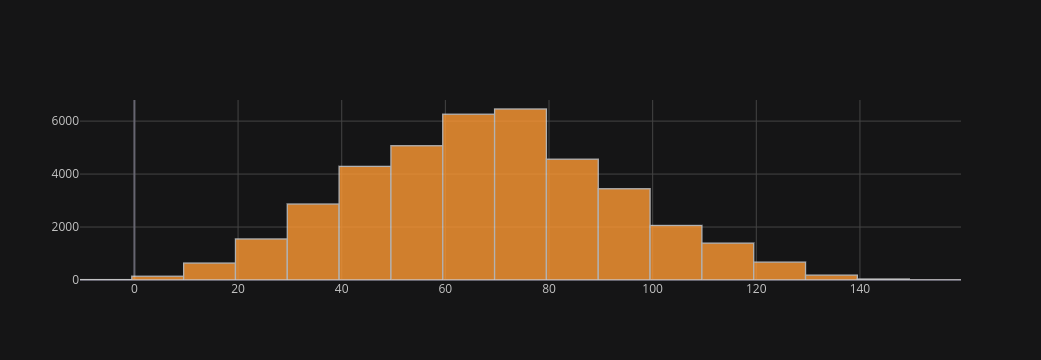

In [153]:
df["score"].iplot(kind="hist", theme="solar", bins=20)

### Scorecard

In [154]:
ls_best

Index(['channel', 'C_kw_min_avg', 'C_LDA_02', 'C_LDA_03',
       'C_global_subjectivity', 'day', 'C_is_weekend', 'C_kw_avg_max',
       'C_max_positive_polarity', 'C_num_keywords'],
      dtype='object')

In [157]:
ls_best_raw = [x[2:] if x.startswith("C_") else x for x in ls_best]

In [158]:
ls_best_raw

['channel',
 'kw_min_avg',
 'LDA_02',
 'LDA_03',
 'global_subjectivity',
 'day',
 'is_weekend',
 'kw_avg_max',
 'max_positive_polarity',
 'num_keywords']

In [159]:
for var in ls_best:
    display(df[[var, "P_" + var]].groupby(var).last())

,P_channel
channel,
,25
bus,3
entertainment,-1
lifestyle,14
socmed,22
tech,11
world,-9


,P_C_kw_min_avg
C_kw_min_avg,
"(-4.614, 721.808]",6
"(1444.616, 2167.424]",2
"(2167.424, 2890.232]",19
"(2890.232, 3613.04]",31
"(721.808, 1444.616]",-13


,P_C_LDA_02
C_LDA_02,
"(-0.00092, 0.184]",9
"(0.184, 0.368]",7
"(0.368, 0.552]",5
"(0.552, 0.736]",0
"(0.736, 0.92]",-4


,P_C_LDA_03
C_LDA_03,
"(-0.000927, 0.185]",7
"(0.185, 0.371]",7
"(0.371, 0.556]",7
"(0.556, 0.741]",7
"(0.741, 0.927]",7


,P_C_global_subjectivity
C_global_subjectivity,
"(-0.001, 0.2]",12
"(0.2, 0.4]",0
"(0.4, 0.6]",8
"(0.6, 0.8]",16
"(0.8, 1.0]",10


,P_day
day,
friday,7
monday,6
saturday,29
sunday,29
thursday,2
tuesday,2
wednesday,2


,P_C_is_weekend
C_is_weekend,
"(-0.001, 0.2]",8
"(0.8, 1.0]",3


,P_C_kw_avg_max
C_kw_avg_max,
"(-843.3, 168660.0]",7
"(168660.0, 337320.0]",6
"(337320.0, 505980.0]",9
"(505980.0, 674640.0]",10
"(674640.0, 843300.0]",9


,P_C_max_positive_polarity
C_max_positive_polarity,
"(-0.001, 0.2]",9
"(0.2, 0.4]",5
"(0.4, 0.6]",6
"(0.6, 0.8]",7
"(0.8, 1.0]",8


,P_C_num_keywords
C_num_keywords,
"(0.991, 2.8]",-31
"(2.8, 4.6]",-7
"(4.6, 6.4]",2
"(6.4, 8.2]",9
"(8.2, 10.0]",13
